#ML/DL ハンズオン (Piper wave X)  
 



・ゴール：ML/DL APPエンジニアとインフラ接点の会話ができるようになる（DX readyなインフラSE）

・コンセプト：複雑さを極力削ぎ落とした例題 （全体把握と時間節約）

・キーワード：モデルと学習と推論、GPU効果, Python, Jupyter Notebook, TensorFlow, Keras

　　　　
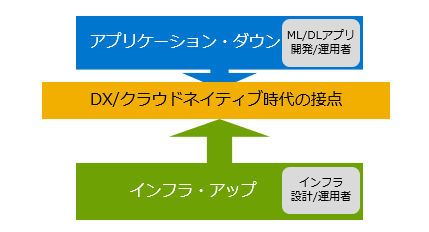

　　　　                    　　　接点はアプリケーション寄りにシフト！

##質問


---
DXとはデジタル化(0,1化) 、ML/DLは？  

## お題：手書き文字（0～9）を認識する学習モデルを作成する



###進め方(ステップ)
1. 実行環境確認　　　　　　：Google Colaboratory（必要に応じて補足）
2. データセット読込と前処理  : MNIST（必要に応じて補足）
3. モデル作成　　　　　　 　 : ニューラルネットワーク定義
4. 学習　　　　　　　　　 　 : GPUによる速度改善
5. 推論　　　　　　　　　 　 : 正解率確認  


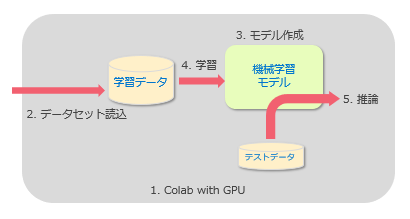



---
質問：理解度は5段階で？（1:low  5:high）


---



### 1. 実行環境：Google Colaboratory（必要に応じて補足）

1)Pythonバージョンの確認　　　   ：2つのセル、実行

2)Hello GURU のコンソール出力　  ：Pythonコード変更、Notebookのsave（ファイル > ドライブにコピーを保存）

3)GPU確認 　　　　　　　　     　　：Tesla K80等



In [ ]:
!python -V              #3.6.9

In [ ]:
#print "Hello GURU!"   # Hello GURU

GPU使用宣言
ランタイム　-> ランタイムタイプの変更 -> "GPU"を選択

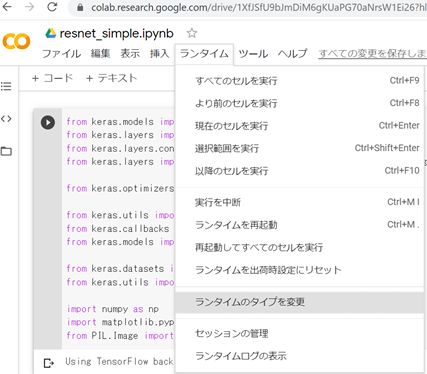

In [ ]:
### GPUの確認
# !apt-get install lshw
!lshw                  # -display: Tesla K80 など(nVIDIA K,M,P,V,T,A)

###2. データセット読込と前処理：MNIST（必要に応じて補足）  
データセット（教師あり）：統一フォーマットでアノテーション済のデータ集合体  
MNISTとは？ ：「手書き数字のサンプルデータ」MLのHello world的データセット（他にCIFAR10など）

- 7万枚 28*28 8bit (学習用6万,テスト用1万)
http://yann.lecun.com/exdb/mnist/


#### これ以降は、学習モデル作成のためのPythonコード


---



In [ ]:
##### ライブラリのインポート
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from __future__ import print_function
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
print(tf.__version__)

In [ ]:
##### MNISTデータ読込

# 定数セット
batch_size = 128               #バッチサイズ 128
num_classes = 10               #分類クラス 10
epochs = 12                    #エポック 12
img_rows, img_cols = 28, 28    # input image dimensions

# 学習用、テスト用データのLOAD
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print ("Done load MNIST")

In [ ]:
### debug MNIST画像の100枚表示
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape((28, 28)), cmap='gray')

In [ ]:
### debug  MNIST画像とラベルの10枚表示
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
# 10枚数の画像に対応するラベルを表示
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

In [ ]:
### debug
p_index = 0                                 ### 0(index)番目データを指定
print("Label:", y_train[p_index])           # ラベル表示

np.set_printoptions(edgeitems=28)
np.core.arrayprint._line_width = 200
print(x_train[p_index])                     # p_index番目のデータをraw表示(数値)

In [ ]:
##### データ前処理（各ビットの0～1化とラベルのOne-hot化）
x_test_bak = x_test
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255                            #255で除算
x_test /= 255                             #255で除算
#print('x_train shape:', x_train.shape)    # (60000, 28, 28, 1)

# convert class vectors to binary class matrices(One-hot)
y_test_bak = y_test
y_train_bak = y_train
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print ("Done pre-process")

In [ ]:
# debug 表示
print("Label:",y_train_bak[p_index])
print(y_train[p_index])                  # One-hot エンコード後のラベル表示

#print(p_index)
#print( 'train samples:', x_train.shape[p_index])  # 学習サンプル数 60000

### 3. モデル作成：ニューラルネットワーク

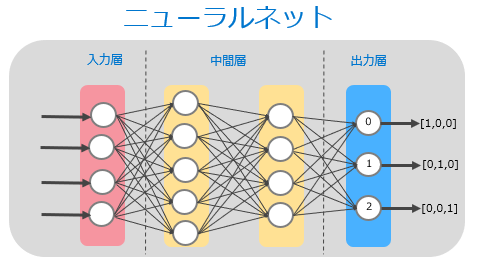

3つの学習モデルを用意：いづれかを選択する（コメントアウト#を外す）  
 - MODEL-A  
 - MODEL-B  
 - MODEL-C

In [ ]:
##### 学習モデルの作成
print(input_shape)
model = Sequential()                                  # Sequentialモデルを定義

### MODEL-A :CNN
# model.add(Conv2D(32, kernel_size=(3, 3),              #32出力 3*3フィルターで畳み込み
#                 activation='relu',
#                 input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))             #2*2でMaxプーリング
# model.add(Conv2D(64, (3, 3), activation='relu'))      #64出力 3*3フィルターで畳み込み
# model.add(MaxPooling2D(pool_size=(2, 2)))             #2*2でMaxプーリング
# model.add(Dropout(0.25))                              #過学習防止のDropout; 0.25の割合で入力を0
# model.add(Flatten())                                  #1次元配列に整形
# model.add(Dense(128, activation='relu'))              #128nodeの中間層
# model.add(Dense(num_classes, activation='softmax'))   #出力層;10 classに分類

### MODEL-B :NN
model.add(Flatten(input_shape=input_shape))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))              #128 or 1000にしてみる
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### MODEL-C : NN
# model.add(Dense(32, activation='relu', input_shape=input_shape))              
# model.add(Flatten())                                  #1次元配列に整形
# model.add(Dense(num_classes, activation='softmax'))

### モデルのコンパイル
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### Optimizer 選択肢
# keras.optimizers.SGD()
# keras.optimizers.RMSprop()
# keras.optimizers.Adagrad()
# keras.optimizers.Adam()
# keras.optimizers.Nadam()
# keras.optimizers.Adadelta()

print("Done modeling")

In [ ]:
### debug 作成したモデルの表示
print("layers:", len(model.layers))  # num of layers 
model.summary()

### 4. 学習: GPUによる速度改善  

In [ ]:
##### 学習
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))     # テストデータを指定（画像とラベル）

In [ ]:
### debug 学習結果の表示
## Accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

## loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()



---


#### 課題1：GPUなしで学習してみる  

　　　　モデル作成からやり直しが必要  

---
#### 課題2：epocの最適値を考える


---




### 5. 推論: 正解率確認  

In [ ]:
##### 推論
predictions = model.predict_classes(x_test, batch_size=batch_size, verbose=1)    # x_testを使い推論する

In [ ]:
### debug 推論結果の表示-1
#print(type(predictions))
x = list(predictions)
y = list(y_test_bak)
# results = pd.DataFrame({'Actual': y, 'Predictions': x})
# output = results[0:10]
# print(output)

### 推論結果の表示-2
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
# MNIST画像の上に推論結果を表示
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.set_title(str(x[i]))
    ax.imshow(x_test_bak[i], cmap='gray')

##### 評価(テストデータでどの程度正解するか？)
score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
print('Test data accuracy:', score[1])
#print(score)

### END ###

### おまけ：学習モデルの保存  


#### 学習済のモデルはファイルとして保存可能（HDF5ファイル形式）

- 再構築可能なモデルの構造  
- モデルの重み  
- 学習時の設定 (loss，optimizer)  
- optimizerの状態．これにより，学習を終えた時点から正確に学習を再開できます

In [ ]:
### 学習モデルの保存：(再利用、移転学習用)
from google.colab import files
model.save('my_piper_model.h5')             # creates a HDF5 file 'my_model.h5'
!ls -l
files.download('my_piper_model.h5')         # ファイルを自分のパソコンに保存

# del model                                # deletes the existing model
# model = load_model('my_model.h5')        # returns a compiled model



---
## 終わりに  

---



質問：理解度は向上したか？　5段階で（1:low  5:high）